# 1-Import des bibliothèques

In [26]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import numpy as np
import time
import json
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import tokenizer_from_json


# 2-Création d'un encodeur et décodeur avec une architecture identique au livrable 3
Paramètres pour le modèle :

In [27]:
embedding_dim = 256
units = 512 # Taille de la couche cachée dans le RNN
top_k = 5000 # Nombre de mots à utiliser dans le vocabulaire
vocab_size = top_k + 1
max_length = 47 # Nombre maximum de mots dans une légende
attention_features_shape = 64 # Taille de la couche d'attention

# 2.1-Création de l'encodeur

In [28]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

# 2.2-Création du décodeur

In [29]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)

        # Couche dense
        y = self.fc1(output)

        y = tf.reshape(y, (-1, x.shape[2]))

        # Couche dense
        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# 3-Initialisation du gestionnaire de checkpoints

In [31]:
checkpoint_path = os.path.abspath("checkpoints/")  # Modifiez ce chemin si nécessaire.
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=tf.keras.optimizers.Adam())  # Assurez-vous d'utiliser les mêmes paramètres d'optimiseur que l'original.
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


# 4-Restaurez le dernier checkpoint

In [32]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Dernier checkpoint restauré !")

Dernier checkpoint restauré !


# 5-Utilisation du modèle sur une image

In [33]:
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    # Lecture du fichier image
    img = tf.io.read_file(image_path)
    # Decodage de l'image en RGB
    img = tf.image.decode_jpeg(img, channels=3)
    # Redimensionnement de l'image en taille (299, 299)
    img = tf.image.resize(img, (299, 299))
    # Normalisation des pîxels de l'image entre -1 et 1
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [34]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [35]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [36]:

# Load the JSON string from the file
with open('tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Recreate the tokenizer from the JSON string
tokenizer = tokenizer_from_json(tokenizer_json)


Prediction Caption: two elephants being walking through the dirt


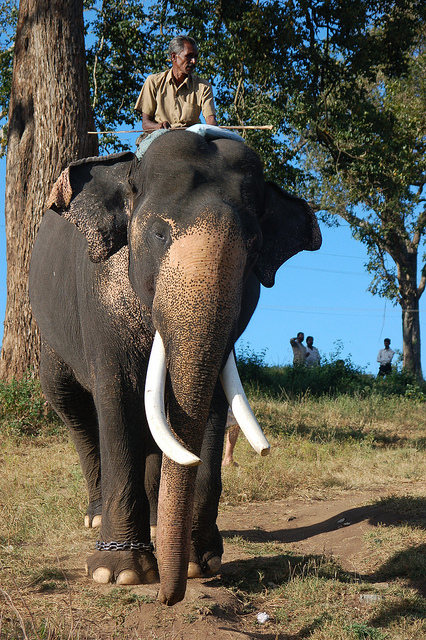

In [37]:
image_folder = "./photo/Photo/"

image_file = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')]

rid = np.random.randint(0, len(image_file))

image_test = image_file[rid]

result, attention_plot = evaluate(image_test)

result = result[:-1]

print ('Prediction Caption:', ' '.join(result))

Image.open(image_test)